In [77]:
# imports

import graphviz
import json
import numpy
import os
import pandas
import psycopg2
import random
import requests
import spotipy
import time
import uuid
from IPython.display import Image
from MusicLibrary import MusicLibrary
from sklearn import tree
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from spotipy.oauth2 import SpotifyOAuth

In [2]:
# read environment variables from local config file

config_directory = os.getcwd() + '/../local/'
exec(open(config_directory+'config.py').read())

In [ ]:
# Spotify API config

scope = "playlist-read-private"
spotify_connection = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope))

In [3]:
# postgres DB config

db_connection = psycopg2.connect(
    dbname=os.environ['LOCAL_DB_DBNAME'],
    user=os.environ['LOCAL_DB_USER'],
    password=os.environ['LOCAL_DB_PASSWORD'],
    host=os.environ['LOCAL_DB_HOST'], 
    port=os.environ['LOCAL_DB_PORT'],
)
cursor = db_connection.cursor()

In [6]:
# query track data for analysis
# alternative 1

cursor.execute("""
    WITH
    
        playlist_tracks AS (
            SELECT
                track_id,
                MIN(added_at) AS min_playlist_added_at,
                COUNT(DISTINCT playlist_id) AS playlist_count
            FROM playlist_track
            GROUP BY track_id
        ),

        track_artists AS (
            SELECT
                track_id,
                COUNT(DISTINCT artist_id) AS artist_count
            FROM track_artist
            GROUP BY track_id
        )
        
    SELECT
        t.id AS track_id,
        t.name AS track_name,
        pt.min_playlist_added_at,
        pt.playlist_count,
        ta.artist_count
    FROM track AS t
        LEFT JOIN playlist_tracks AS pt
            ON t.id = pt.track_id
        LEFT JOIN track_artists AS ta
            ON t.id = ta.track_id
    ;
""")

result = cursor.fetchall()

for row in result:
    print(row)
    break

('3pyPyRSFvIOMNS3S2CeMDB', 'Jolie Fille', '2025-04-27T20:33:07Z', 1, 4)


In [7]:
# close postgres DB

cursor.close()
db_connection.close()

In [3]:
# fetch data via class object
# alternative 2

lib = MusicLibrary()
if lib.load_data_from_db() is True:
    print(lib)

Music Library Contents
 album: 1006
 artist: 1016
 genre: 103
 label: 473
 playlist: 65
 track: 1108
 album_genre: 0
 album_label: 1006
 album_track: 1108
 artist_genre: 1837
 playlist_track: 1223
 track_artist: 1736
 playlist_backlog: 90


In [11]:
# aggregate track artists

ta_df = lib.get_object_dataframe('track_artist')
ta_agg_df = ta_df.groupby('track_id').agg(
    artist_count=('artist_id', 'nunique'),
)
ta_agg_df.describe()

,artist_count
count,1108.000000
mean,1.566787
std,0.749621
min,1.000000
25%,1.000000
50%,1.000000
75%,2.000000
max,5.000000


In [43]:
# aggregate playlist tracks

pt_df = lib.get_object_dataframe('playlist_track')
pt_agg_df = pt_df.groupby('track_id').agg(
    playlist_count=('playlist_id', 'nunique'),
    min_playlist_added_at=('added_at', 'min'),
)
pt_agg_df['min_playlist_added_at'] = pandas.to_datetime(pt_agg_df['min_playlist_added_at'], format='%Y-%m-%dT%H:%M:%SZ')
pt_agg_df.describe()

,playlist_count,min_playlist_added_at
count,1108.000000,1108
mean,1.103791,2024-06-30 09:19:49.160649728
min,1.000000,2020-06-23 18:58:46
25%,1.000000,2024-03-02 02:06:49
50%,1.000000,2024-12-30 17:25:53.500000
75%,1.000000,2024-12-31 16:49:28.750000128
max,3.000000,2025-05-16 11:50:56
std,0.316747,NaN


In [56]:
# combine album track data

at_df = pandas.merge(
    lib.get_object_dataframe('album'), 
    lib.get_object_dataframe('album_track'), 
    left_on='id', right_on='album_id', how='inner'
)[[
    'name',
    'release_date',
    'total_tracks',
    'album_id',
    'track_id',
    'track_number'
]]
at_df = at_df.rename(columns={
    'name': 'album_name', 
    'total_tracks': 'album_total_tracks',
})
at_df['release_date_is_valid'] = 0
at_df.loc[at_df['release_date'].str.len() == 10, 'release_date_is_valid'] = 1
at_df['valid_release_date'] = None
at_df.loc[at_df['release_date_is_valid'] == 1, 'valid_release_date'] = pandas.to_datetime(at_df['release_date'][at_df['release_date_is_valid'] == 1], format='%Y-%m-%d')
at_df.head()

,album_name,release_date,album_total_tracks,album_id,track_id,track_number,release_date_is_valid,valid_release_date
0,Jolie Fille,2024-07-26,1,7x1lI7V6hPlNkQtcuRCrnV,3pyPyRSFvIOMNS3S2CeMDB,1,1,2024-07-26 00:00:00
1,I Adore You (feat. Daecolm),2024-07-19,1,5MrdEMJrBnauBJsd1nYY00,5nPbKG04fhLkIAjcPFaZq7,1,1,2024-07-19 00:00:00
2,TOO COOL TO BE CARELESS,2024-07-05,1,17zk2lz0xesn8Y4YncohZa,6KqM3xmPIDonsTjCSGrrr5,1,1,2024-07-05 00:00:00
3,Move,2024-06-07,1,4M8ThNHbNjda2cPwL8XZHS,1BJJbSX6muJVF2AK7uH1x4,1,1,2024-06-07 00:00:00
4,Never Walk Alone,2025-02-14,12,5B6cE705BTRvviiO1p4m0o,1bE98D49uKNetOyLiaB8tG,1,1,2025-02-14 00:00:00


In [38]:
# inspect track data

t_df = lib.get_object_dataframe('track')
t_df = t_df.rename(columns={
    'name': 'track_name', 
    'popularity': 'track_popularity',
})
t_df.head()

,id,track_name,duration_ms,track_popularity,url,isrc
0,3pyPyRSFvIOMNS3S2CeMDB,Jolie Fille,194442,64,https://open.spotify.com/track/3pyPyRSFvIOMNS3...,BX0BA2400057
1,5nPbKG04fhLkIAjcPFaZq7,I Adore You (feat. Daecolm),214000,89,https://open.spotify.com/track/5nPbKG04fhLkIAj...,DECE72401347
2,6KqM3xmPIDonsTjCSGrrr5,TOO COOL TO BE CARELESS,220046,80,https://open.spotify.com/track/6KqM3xmPIDonsTj...,GBKQU2462686
3,1BJJbSX6muJVF2AK7uH1x4,Move,177598,88,https://open.spotify.com/track/1BJJbSX6muJVF2A...,DEEC33501508
4,1bE98D49uKNetOyLiaB8tG,Never Walk Alone,188360,75,https://open.spotify.com/track/1bE98D49uKNetOy...,NL8RL2429546


In [58]:
# merge data for analysis

pre_track_data_1 = pandas.merge(t_df, at_df, left_on='id', right_on='track_id', how='left')
pre_track_data_2 = pandas.merge(pre_track_data_1, ta_agg_df, left_on='id', right_on='track_id', how='left')
track_data = pandas.merge(pre_track_data_2, pt_agg_df, left_on='id', right_on='track_id', how='left')
track_data['one_track_album'] = 0
track_data.loc[track_data['album_total_tracks'] == 1, 'one_track_album'] = 1
track_data['release_diff_days'] = None
track_data['valid_release_date'] = pandas.to_datetime(track_data['valid_release_date'])
track_data.loc[track_data['release_date_is_valid'] == 1, 'release_diff_days'] = (track_data[track_data['release_date_is_valid'] == 1]['min_playlist_added_at'] - track_data[track_data['release_date_is_valid'] == 1]['valid_release_date']).dt.days
track_data.head()

,id,track_name,duration_ms,track_popularity,url,isrc,album_name,release_date,album_total_tracks,album_id,track_id,track_number,release_date_is_valid,valid_release_date,artist_count,playlist_count,min_playlist_added_at,one_track_album,release_diff_days
0,3pyPyRSFvIOMNS3S2CeMDB,Jolie Fille,194442,64,https://open.spotify.com/track/3pyPyRSFvIOMNS3...,BX0BA2400057,Jolie Fille,2024-07-26,1,7x1lI7V6hPlNkQtcuRCrnV,3pyPyRSFvIOMNS3S2CeMDB,1,1,2024-07-26,4,1,2025-04-27 20:33:07,1,275
1,5nPbKG04fhLkIAjcPFaZq7,I Adore You (feat. Daecolm),214000,89,https://open.spotify.com/track/5nPbKG04fhLkIAj...,DECE72401347,I Adore You (feat. Daecolm),2024-07-19,1,5MrdEMJrBnauBJsd1nYY00,5nPbKG04fhLkIAjcPFaZq7,1,1,2024-07-19,4,1,2025-04-27 20:35:35,1,282
2,6KqM3xmPIDonsTjCSGrrr5,TOO COOL TO BE CARELESS,220046,80,https://open.spotify.com/track/6KqM3xmPIDonsTj...,GBKQU2462686,TOO COOL TO BE CARELESS,2024-07-05,1,17zk2lz0xesn8Y4YncohZa,6KqM3xmPIDonsTjCSGrrr5,1,1,2024-07-05,1,1,2025-04-27 20:38:53,1,296
3,1BJJbSX6muJVF2AK7uH1x4,Move,177598,88,https://open.spotify.com/track/1BJJbSX6muJVF2A...,DEEC33501508,Move,2024-06-07,1,4M8ThNHbNjda2cPwL8XZHS,1BJJbSX6muJVF2AK7uH1x4,1,1,2024-06-07,5,1,2025-04-27 20:46:30,1,324
4,1bE98D49uKNetOyLiaB8tG,Never Walk Alone,188360,75,https://open.spotify.com/track/1bE98D49uKNetOy...,NL8RL2429546,Never Walk Alone,2025-02-14,12,5B6cE705BTRvviiO1p4m0o,1bE98D49uKNetOyLiaB8tG,1,1,2025-02-14,2,1,2025-04-27 21:02:00,0,72


In [63]:
# simple tree example to understand popularity

y = track_data[track_data['release_date_is_valid'] == 1].track_popularity
X = track_data[track_data['release_date_is_valid'] == 1][[
    'duration_ms',
    'artist_count',
    'playlist_count',
    'album_total_tracks',
    'one_track_album',
    'track_number',
    'release_diff_days',
]]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 4)

In [60]:
# create a function for testing models

def model_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):
    model = tree.DecisionTreeRegressor(max_leaf_nodes=max_leaf_nodes, random_state=4)
    model.fit(train_X, train_y)
    predictions = model.predict(val_X)
    mae = mean_absolute_error(val_y, predictions)
    return(mae)

In [66]:
# evaluate model nodes amounts

for n in range(2,50):
    if n % 2 == 0:
        m = model_mae(n, train_X, val_X, train_y, val_y)
        print("Max leaf nodes: %d  \t\t Mean Absolute Error:  %d" %(n, m))

Max leaf nodes: 2  		 Mean Absolute Error:  15
Max leaf nodes: 4  		 Mean Absolute Error:  15
Max leaf nodes: 6  		 Mean Absolute Error:  14
Max leaf nodes: 8  		 Mean Absolute Error:  14
Max leaf nodes: 10  		 Mean Absolute Error:  14
Max leaf nodes: 12  		 Mean Absolute Error:  14
Max leaf nodes: 14  		 Mean Absolute Error:  14
Max leaf nodes: 16  		 Mean Absolute Error:  14
Max leaf nodes: 18  		 Mean Absolute Error:  14
Max leaf nodes: 20  		 Mean Absolute Error:  14
Max leaf nodes: 22  		 Mean Absolute Error:  14
Max leaf nodes: 24  		 Mean Absolute Error:  14
Max leaf nodes: 26  		 Mean Absolute Error:  14
Max leaf nodes: 28  		 Mean Absolute Error:  14
Max leaf nodes: 30  		 Mean Absolute Error:  14
Max leaf nodes: 32  		 Mean Absolute Error:  14
Max leaf nodes: 34  		 Mean Absolute Error:  14
Max leaf nodes: 36  		 Mean Absolute Error:  14
Max leaf nodes: 38  		 Mean Absolute Error:  14
Max leaf nodes: 40  		 Mean Absolute Error:  15
Max leaf nodes: 42  		 Mean Absolute Error: 

In [71]:
# choose a model to inspect

chosen_model = tree.DecisionTreeRegressor(max_leaf_nodes=22, random_state=4)
chosen_model.fit(train_X, train_y)
chosen_predictions = chosen_model.predict(val_X)
chosen_mae = mean_absolute_error(val_y, chosen_predictions)

0.3741090169502751


In [79]:
# visualize @ http://webgraphviz.com/

tree.export_graphviz(chosen_model, out_file='tree.dot')

None


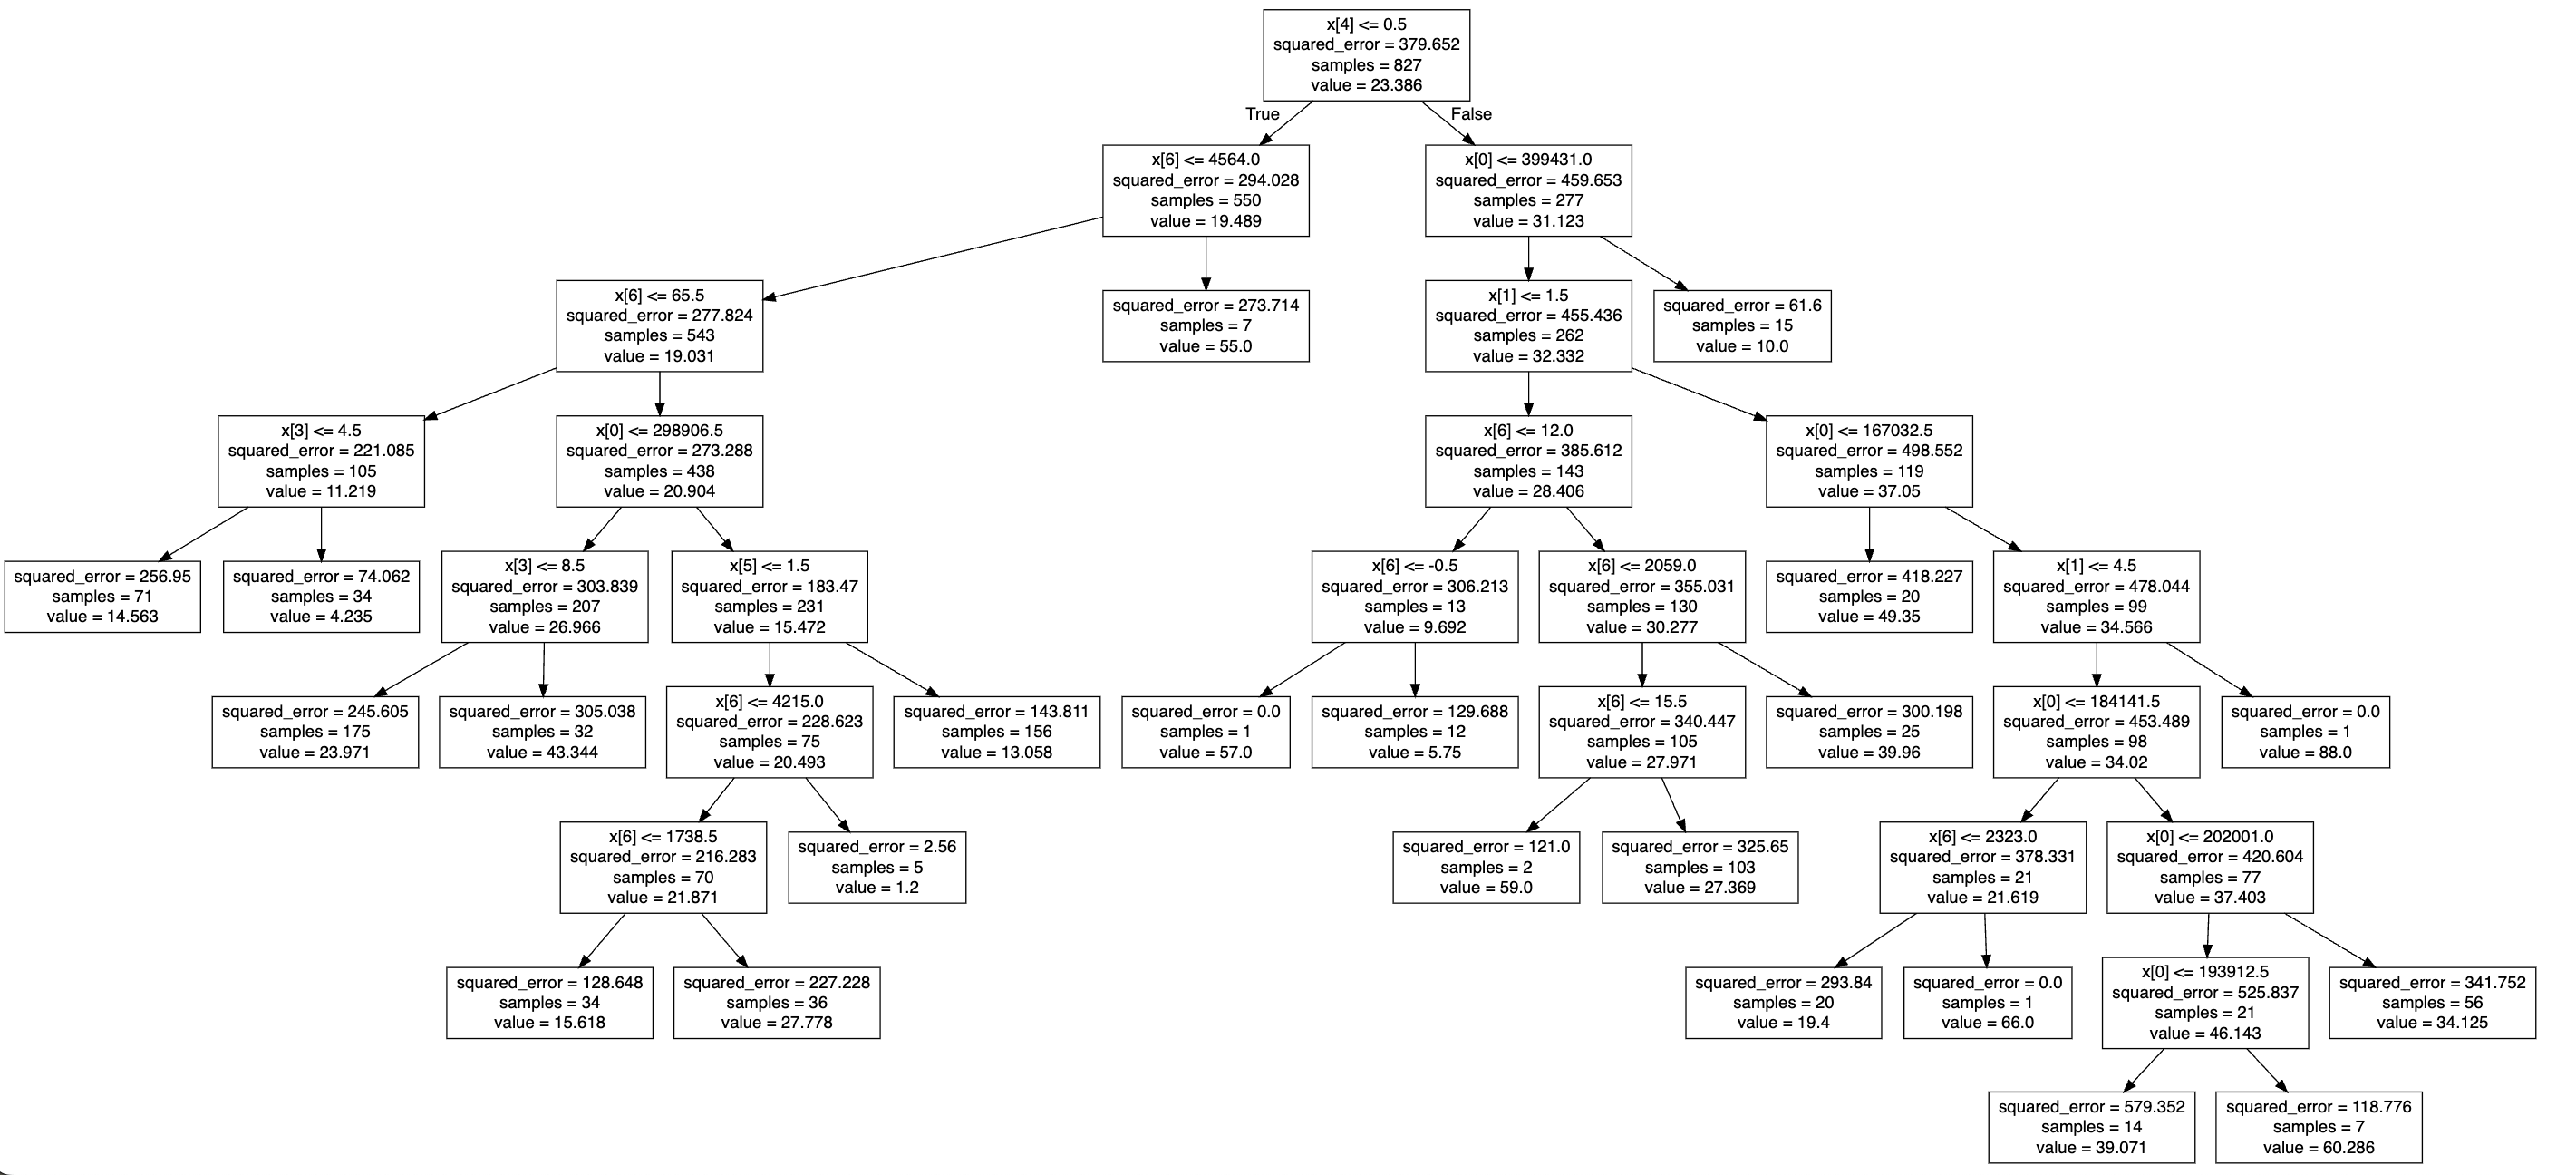

In [80]:
# show image in notebook

Image("tree_image.png")